<img style="float: right; width: 200px;"
    src="http://www.polymtl.ca/profiles/portail/themes/custom/bueno/logo.png">
<h1>hyperNN : Neural network hyperparameter optimization</h1>
<h3>Pierre Hulot & Antoine Prouvost</h3>
<h3>INF8225 - Artificial Intelligence</h3>

In [7]:
import json, plots
import numpy as np

## Abstract

Neural networks are very popular nowadays, with a lot of libraries offering very efficient way of using them. Many problems are solvable using a neural network, but finding the right one, the more efficient, the more accurate is very complex and time consuming. Finding the optimal parameters of a neural network can be difficult. People are used to optmise them by hand, using their knowledge on neural networks. The effort required to find an optimal or quasi optimal configuration is so high that people usually use non-optmized netwoks. In this report we compare a few solutions proposed to optimize these parameters. We applyed the solutions on the dataset MNIST.

## Previous work

present the implemented articles

## 1. The Problem to optimize

### The Dataset

For this project we used the well known dataset MNIST. The dataset is composed by 80 000 classified images reprensenting the numbers from 0 to 9. 
The training set is composed of 60 000 images, the test set and the validation set 10 000. We do not use any augmentation.

### The Model

We choose to implement the model using Keras (python library). We used both tensorflow and Theano as the underlying layer.<br>
The basic model is a logistic regression with 784 inputs and 10 outputs using as loss the categorical crossentropy and as optimizer a SGD. 
We choose to fix the __number of epochs to 100__ and the __batch size to 200__. This choice was made to simplify the problem and to impose the network to find a solution in a reasonable time.<br>

All remaning parameters are used for the optimisation.<br>

One MNIST training took 1-2 minutes on our computers.<br>

### Choice of hyperparameters

We choose for this project to optimise the network on the following parameters with a stochastic gradient descent optimisation:
- The __number of layers__ : from 0 to 3
- The __number of neurons per layer__ : from 0 to 500
- The __learning rate__ : from 0 to 1
- The __L1 regularisation__ coefficient : from 0 to 1
- The __L2 regularisation__ coefficient : from 0 to 1
- The __momentum__ (wheight of previous gradient in SGD): from 0 to 1
- The __decay__ for the learning rate : from 0 to 1
- The __nesterov__ method for calculating momentums : true or false
- The __activation__ function of all hidden layers : tanh, sigmoid or relu

The number of layers and neurons is a strict policy as it controls the capacity of the model. However, for the other ranges, this is more of a general guideline. There are here to guide the algorithm toward "relevant values". When an algorithm would not behave well close to zero or with too large values, we would ajust them a little.
This is a tradeoff between the maximum accuracy possible and the convergence of the algorithm.

### Comparing models

The measure for one set of hyperparameters is the __validation accuracy__ after the training of the full training set (100 epochs).

For a pure theorical approch, we would need to run the an algorithm on a fixed number of training on MNIST (e.g. 200) multiple times to account for the probabilistic perspective of the algorithm.
We would also need to repeat this operation on a number of problem different than MNIST. We clearly do not have this kind of computing power.

Running a specific algorithm also need to adjust a couple of parameters (hopefully less than training MNIST), or even small redefinitions of the problem as stated previously. This kind of intervention is hard to account for on a theorical level.

Therefore, we will compare the different algorithms from the perspective of an individual trying to optimize the training of his neural network. The individual can make some obvious adjustments but expects the optimisation algorithm to do the heavy lifting.

## 2. hyperRand: random search

The most natural idea after bruteforce is to explore a random search. Any solution comparing worse to this solution cannot be retained as a good solution.
We used the following marginal probabilty distribution to sample for our experiments:
- The __number of layers__ is __fixed__ to 2
- The __number of neurons per layer__ is sampled from a __poisson__ distribution of parameter 200
- The __learning rate__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __L1 regularisation__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __L2 regularisation__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __momentum__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __decay__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __nesterov__ is sample from a __uniform__ distribution
- The __activation__ is sample from a __uniform__ distribution

The number of layer has been fixed to 2 layers to compare better with [hyperMads](#4.-hyperMads:-MADS-algorithm) and hyper that we didn't have time to run on more than three layers [hyperBayes](#5.-hyperBayes:-Bayesian-optimisation). The conclusion would not change thought.

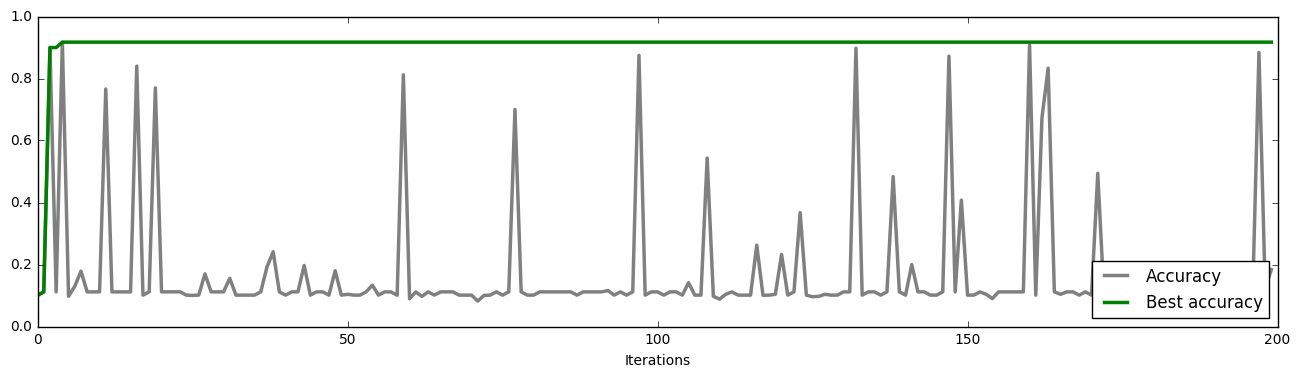

In [17]:
accRand = np.array(map(lambda j: j["Accuracy"],
                       json.load(open("results/hyperRand.json", "r"))))
plots.accuracy(accRand)

In [18]:
print("Best accuracy: {}".format(accuracy.max()))
print("Number of solutions better than 80%: {}".format(np.sum(accuracy >= .8)))

Best accuracy: 0.9173
Number of solutions better than 80%: 10


With only ten solutions better than 80%, and a maximum accuracy of 91.73%, the random search is a __bad algorithm__ for finding good optimal solutions.
One could arguee that the solutions found could be used to initialize another algorithm but all other algorithm already have their own way of generating and exploiting randomness.

In a way, the results really depends on the probabilistic distributions given for the parameters. An extreme case would be the a distribution with little to no variance around an optimal solution. This distribution would perform well but require a dramatic amount of knowledge from the indivual running the algorithm.

The strengths of this algorithm is that it's easy to set up and easy to parallelize (no synchronizing steps).

## 3. hyperLearn: NN desning NN

For this approach we've re-implemented the solution proposed by ............... in the paper ............. 

### Approach : 

The idea of NN designing NN is to learn a neural network that tries to predict the performance of a Network givens its parameters. The complicated point of this approach is to generate some points on which the neural network can learn, then to refine the neural network on interessant zones to find the optimal solution. The sampling of training points is essential.

### The algorithm

sample some random hyperparameters and train MNIST on them
train the neural network (RSM)
```python
a = 1e-4
while (n_iteration < max_iter):
    sample a random parameter
    predict its performance p
    if (p> max_performance):
        with probability (1-a):
            train_MNIST
            add result in RSM training set
            train the RSM
            update max_performance if necessary
        else do nothing
    else :
        with probability a
            train_MNIST
            add result in RSM training set
            train the RSM
            update max_performance if necessary
        else do nothing
return the best configuration
```

### The sampling

The previous algorithm is very dependant on sampling hyperparameters to test. The sampling method is a variation of Metropolis–Hastings algorithm. The first sample are random, the following are sampled with a gaussian distribution around the previous one. This method enable a local search around the optimal solution found, but also allows the exploration of the rest of the search space. 

We've beginned using when possible continous hyperparameters values. But this approach was stuck is a local minima and was not able to explore the entire space to find a good solution. This bad result is understandable because of the meaning of the values : a learning rate of 0.1 is very similar to a leaning rate of 0.13, but a learning rate of 0.001 is quite different of a learning rate of 0.031. The gaussian distribution doesn't make any difference between these two examples. Then we followed what was done in the article and we discretized the search space. This way we were able to counter the previous problem, but we've lost in the precision of the optained solution. <br>
Here are the possible values of the parameters : 

```python
values = np.array([
    [0, 1, 2, 3],  #n_couches
    range(10, 500, 10), range(10, 500, 10), range(10, 500, 10),  #couches
    [0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #learning rate
    [0.000001,0.00001,0.0001,0.001,0.01,0.1],  #reg_l1
    [0.000001,0.00001,0.0001,0.001,0.01,0.1],  #reg_l2
    [0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #moment
    [.0,0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #decay
    [0,1],  #nesterov
    [0, 1, 2]  #activation
])
```

## 4. hyperMads: MADS algorithm

## 5. hyperBayes: Bayesian optimisation

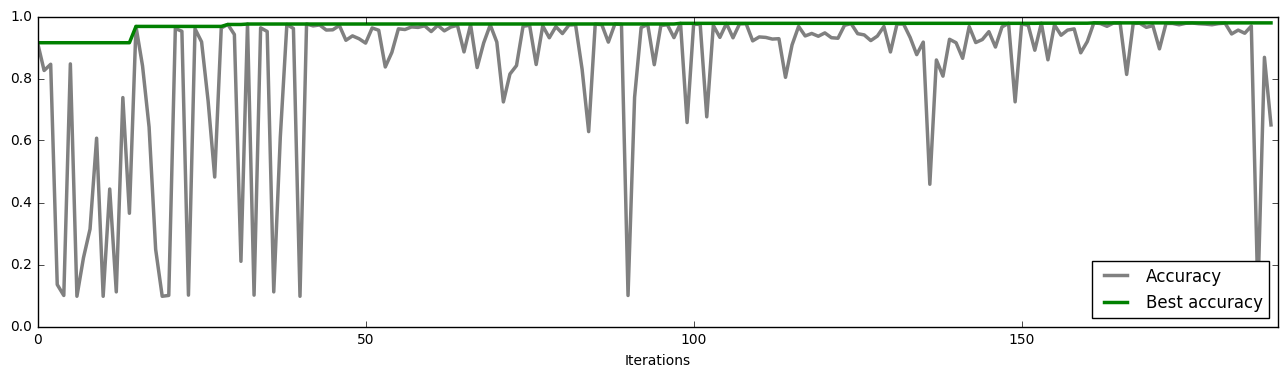

In [23]:
accBayes = np.array(map(lambda j: j["Accuracy"],
                        json.load(open("results/hyperBayes3.json", "r"))))
plots.accuracy(accBayes)

In [24]:
accBayes.max()

0.97940000000000005

## 6. Working together

## Reference and acknowledgements

Our experimentation would not be possible without the use of these great tools:
* __[Theano](https://github.com/Theano/Theano)__ Symbolic calculation library
* __[TensorFlow](https://www.tensorflow.org)__ Tensor manipulation
* __[Keras](https://github.com/fchollet/keras)__ Deep learning library
* __[NOMAD](https://www.gerad.ca/nomad/Project/Home.html)__ and __[OPAL](http://pythonoptimizers.github.io/opal/)__ Software for black box optimiaztion
* __[Spearmint](https://github.com/HIPS/Spearmint)__ Software to perform bayesian optimization

#### References
LeCun, Y., Cortes, C., & Burges, C. J. (1998). The MNIST database of handwritten digits.

Audet, C., & Dennis Jr, J. E. (2006). Mesh adaptive direct search algorithms for constrained optimization. SIAM Journal on optimization, 17(1), 188-217.

Audet, C., Dang, C. K., & Orban, D. (2011). Algorithmic parameter optimization of the DFO method with the OPAL framework. In Software Automatic Tuning (pp. 255-274). Springer New York.

Smithson, S. C., Yang, G., Gross, W. J., & Meyer, B. H. (2016). Neural networks designing neural networks: multi-objective hyper-parameter optimization. arXiv preprint arXiv:1611.02120.

Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical bayesian optimization of machine learning algorithms. In Advances in neural information processing systems (pp. 2951-2959).

Snoek, J., Rippel, O., Swersky, K., Kiros, R., Satish, N., Sundaram, N., ... & Adams, R. P. (2015, February). Scalable Bayesian Optimization Using Deep Neural Networks. In ICML (pp. 2171-2180).

Spearmint software. (n.d.). Retrieved from https://github.com/HIPS/SpearmintHarvard Intelligent Probabilistic Systems Group